<!--NOTEBOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="./figures/LogoOpenclassrooms.png">
<font size="4">
    
Cette étude a été réalisée dans le cadre du 6ème projet de ma formation Datascientist dispensée en MOOC par 

<font color='blus'>Openclassrooms / écoles Centrale-Supélec</font>.




<p></p><p></p><p></p>





**Le problème posé :**


*Stack Overflow est un site célèbre de question-réponses liées au développement informatique. Pour poser une question sur ce site, il faut entrer plusieurs tags de manière à retrouver facilement la question par la suite. Pour les utilisateurs expérimentés cela ne pose pas de problème, mais pour les nouveaux utilisateurs, il serait judicieux de suggérer quelques tags relatifs à la question posée.*

*Amateur de Stack Overflow, qui vous a souvent sauvé la mise, vous décidez d'aider la communauté en retour. Pour cela, vous développez un système de suggestion de tags pour le site. Celui-ci prendra la forme d’un algorithme de machine learning qui assigne automatiquement plusieurs tags pertinents à une question.*



**Solutions mises en oeuvre**

Les solutions de suggestion de tags présentés ici se basent sur des modèles *non-supervisés* de machine learning.

Les modèles mis en oeuvre : 
    * Clusterisation par K-means
    * LDA
    * Word2Vec

Ce notebook utilise les données issues du notebook **P6_DadaAnalysis.ipynb**



# 3. Unsupervised methods

TAGS are regarded as keywords.

Aims of this section is to create data points then identify clusters from this set of data.

These data-points are digital representation of the cleaned documents dataset.

For each-one of the clusters, most representative terms will be identified.

These terms will be considered as TAGs.

Differents embeddings techniques will be used in order to create data-points : 

* Bag of words
* Co-occurence
* TF-IDF

**Loading train dataset and extract users questions from Body column**

In [42]:
import pandas as pd
file_name="./data/train_StackOverFlow_BodyTitleTags.csv"
df_sof_train=pd.read_csv(file_name)
print(df_sof_train.shape)

(24604, 5)


In [43]:
import p6_util
df_document_std = p6_util.p6_df_standardization(df_sof_train,is_stemming=False, is_lem=False)


Cleaning text in-between markers <code></code> markers...

Cleaning LXML markers...

Remove verbs from sentences...

Filtering alpha-numeroc words from sentences...

Removing stopwords...


**Save standardization**

In [44]:
import p5_util
file_name="./data/df_document_std.dump"
p5_util.object_dump(df_document_std, file_name)

**Load standardized corpus**

In [45]:
import p5_util
file_name="./data/df_document_std.dump"
df_document_std = p5_util.object_load(file_name)

p5_util.object_load : fileName= ./data/df_document_std.dump


#### Corpus vectorization

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer

# When building vacabulary, terms with frequency document < p_min_df are ignored.
p_min_df = 0.001
# When building vacabulary, terms with frequency document> p_max_df are ignored.
p_max_df = 1.


dict_sof_document = df_document_std.Body.to_dict()

ngram1=2
ngram2=2
vectorizer=TfidfVectorizer(norm="l2", use_idf=True, min_df=p_min_df, max_df=p_max_df, ngram_range=(ngram1, ngram2))

csr_matrix = vectorizer.fit_transform(dict_sof_document.values())

print(csr_matrix.shape)

(24604, 898)


**Save vectorization**

In [48]:
import p5_util
file_name="./data/csr_matrix_tdif_ngram_2_2.dump"
p5_util.object_dump(csr_matrix, file_name)

file_name="./data/vectorizer_tdif_ngram_2_2.dump"
p5_util.object_dump(vectorizer, file_name)

## 3.1 Kmeans clustering

**Load vectorization operator and CSR matrix**

In [49]:
import p5_util
file_name="./data/csr_matrix_tdif_ngram_2_2.dump"
csr_matrix = p5_util.object_load(file_name)
print(csr_matrix.shape)

file_name="./data/vectorizer_tdif_ngram_2_2.dump"
vectorizer = p5_util.object_load(file_name)

p5_util.object_load : fileName= ./data/csr_matrix_tdif_ngram_2_2.dump
(24604, 898)
p5_util.object_load : fileName= ./data/vectorizer_tdif_ngram_2_2.dump


**Proceed to Kmeans clustering**

In [50]:
from sklearn.cluster import KMeans
n_cluster=100
cluster_kmean=KMeans(n_clusters=n_cluster).fit(csr_matrix)

print(len(cluster_kmean.labels_))

24604


**Save Kmeans clustering**

In [51]:
file_name="./data/cluster_kmeans_labels_100.dump"
p5_util.object_dump(cluster_kmean.labels_, file_name)

**For each cluster build a TAG list**

In [52]:
file_name="./data/cluster_kmeans_labels_100.dump"
cluster_kmean_labels = p5_util.object_load(file_name)

p5_util.object_load : fileName= ./data/cluster_kmeans_labels_100.dump


In [72]:
import p6_util
p_tag_ratio=1.0
dict_list_cluster_tag, dict_cluster_stat, dict_df_freq_cluster_tag \
= p6_util.get_dict_list_cluster_tag(cluster_kmean_labels, dict_sof_document, vectorizer, p_tag_ratio)

Cluster #0 : Number of documents= 35 : Done!
Cluster #1 : Number of documents= 14958 : Done!
Cluster #2 : Number of documents= 67 : Done!
Cluster #3 : Number of documents= 122 : Done!
Cluster #4 : Number of documents= 123 : Done!
Cluster #5 : Number of documents= 118 : Done!
Cluster #6 : Number of documents= 495 : Done!
Cluster #7 : Number of documents= 32 : Done!
Cluster #8 : Number of documents= 385 : Done!
Cluster #9 : Number of documents= 136 : Done!
Cluster #10 : Number of documents= 48 : Done!
Cluster #11 : Number of documents= 73 : Done!
Cluster #12 : Number of documents= 24 : Done!
Cluster #13 : Number of documents= 112 : Done!
Cluster #14 : Number of documents= 54 : Done!
Cluster #15 : Number of documents= 110 : Done!
Cluster #16 : Number of documents= 173 : Done!
Cluster #17 : Number of documents= 57 : Done!
Cluster #18 : Number of documents= 426 : Done!
Cluster #19 : Number of documents= 49 : Done!
Cluster #20 : Number of documents= 98 : Done!
Cluster #21 : Number of documen

In [73]:
import p5_util
file_name="./data/dict_list_cluster_tag.dump"
p5_util.object_dump(dict_list_cluster_tag, file_name)

#### Plot cluster distribution

In [74]:
import pandas as pd
# Convert dictionary as dataframe allowing having statisticals values
df_cluster_stat = pd.DataFrame.from_dict(dict_cluster_stat, orient='index')
df_cluster_stat.rename(columns={0:'cluster'},inplace=True)

min_cluster_count = min(df_cluster_stat.cluster)
max_cluster_count = max(df_cluster_stat.cluster)

#Get outliers clusters : mix and max values
cluster_max_id = df_cluster_stat.query("cluster == "+str(max_cluster_count), inplace=False).index[0]
cluster_min_id = df_cluster_stat.query("cluster == "+str(min_cluster_count), inplace=False).index[0]

print("Cluster {} : elements= {} ".format(cluster_min_id, min_cluster_count))
print("Cluster {} : elements= {} ".format(cluster_max_id, max_cluster_count))


Cluster 56 : elements= 1 
Cluster 1 : elements= 14958 


**Display Questions distribution among clusters**

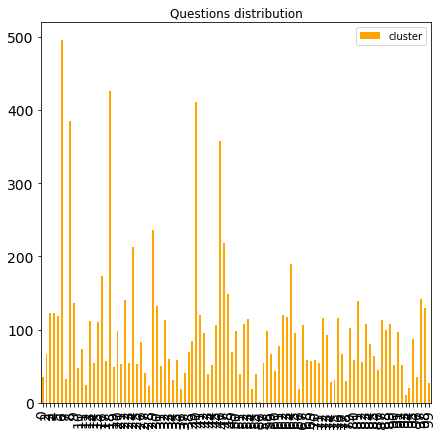

In [75]:
df_cluster_stat.query("cluster <= 1000", inplace=True)
ax = df_cluster_stat.plot.bar(figsize=(7, 7), title="Questions distribution", color='orange', fontsize=14)

**Display cluster with lower number of elements**

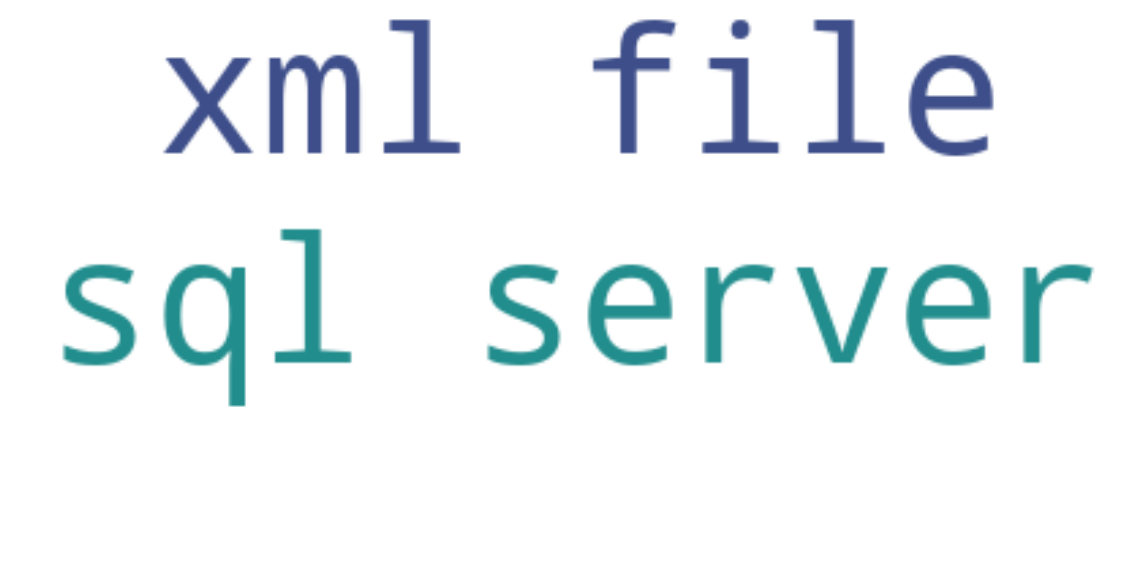

In [76]:
import p6_util_plot
df_freq_cluster_tag = dict_df_freq_cluster_tag[cluster_min_id]
dict_freq_cluster_tag = df_freq_cluster_tag.to_dict()['Freq']
p6_util_plot.display_word_cloud(dict_freq_cluster_tag)

In [78]:
print(dict_list_cluster_tag[cluster_min_id])
print("\n")
#print(dict_list_cluster_tag[cluster_max_id])

sql_server xml_file




**Display cluster with greater number of elements**

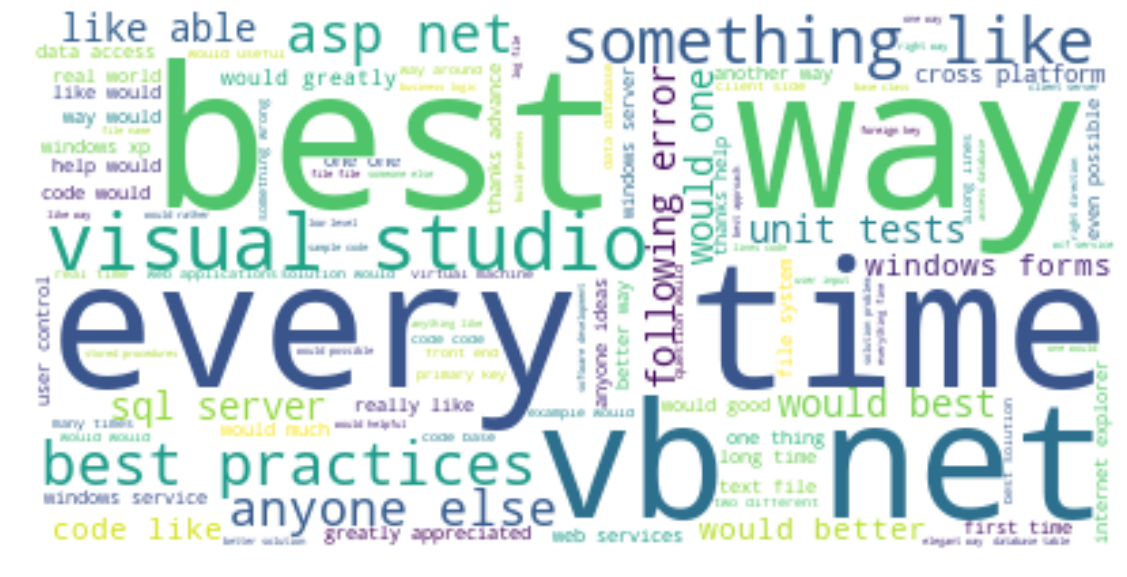

In [77]:
import p6_util_plot
df_freq_cluster_tag = dict_df_freq_cluster_tag[cluster_max_id]
dict_freq_cluster_tag = df_freq_cluster_tag.to_dict()['Freq']
p6_util_plot.display_word_cloud(dict_freq_cluster_tag)

## Testing process

Questions (Posts) are vectorized.

Vectorization leads to a Matrix.

Transpozed matrix is clusterized : transpozed matrix columns are questions (Posts).

A clustering algorythm is applied over transposed matrix. Each cluster compound a set of questions.

Each cluster is assigned with some TAGs that way : 

* In any cluster, TAGs are picked up from vectors components.

* For each one of the cluster element : 
    * Greatest components values are picked up.
    * TAGs assigned are vocabulary terms matching with picked-up values.


**Extract a question from test data-set**

**Loading test dataset**

In [79]:
import pandas as pd
file_name="./data/test_StackOverFlow_BodyTitleTags.csv"
df_sof_test=pd.read_csv(file_name)

In [81]:
import random
import p6_util

i_random = random.choice(range(0, df_sof_test.shape[0]))
question= df_sof_test.Body.iloc[i_random]
print("\nQuestion : \n")
print(question)


Question : 

<p>I'm a .NET developer, and worked with VB6 before that.  I've become very familiar with those environments, and working in the context of garbage collected languages.  However, I now wish to bolster my skillset with native C++ and find myself a bit overwhelmed.  Ironically, it's not what I'd imagine is the usual stumbling blocks for beginners as I feel that I've got the grasp of pointers and memory management fairly well.  The thing that's a bit confusing for me is more along the lines of:</p>

<ul>
<li>Referencing/using other libraries</li>
<li>Exposing <em>my</em> libraries for others to use</li>
<li>String handling</li>
<li>Data type conversions</li>
<li>Good project structure</li>
<li>Data structures to use (ie. in C#, I use <code>List&lt;T&gt;</code> a lot, what do I use in C++ that works simiarly?)</li>
</ul>

<p>It almost feels like depending on the IDE you use, the guidelines are different, so I was really looking for something that's perhaps a bit more universa

**Question is standardized**

In [82]:
import p6_util

df_std =p6_util.preprocess_post(question, is_stemming=False, is_lem=True, is_stopword=True\
    ,is_stopverb=True, is_stopalfanum=True)

In [83]:
post_std = df_std.to_dict()['Body'][0]
print(post_std)

net developer vb6 familiar environment context garbage however wish skillset native c++ bit overwhelmed ironically imagine usual stumbling block beginner grasp pointer memory management fairly well thing bit along line library others handlingdata type conversionsgood project structure ie c # lot use c++ simiarly almost feel like ide guideline different really something perhaps bit universal worst microsoft compiler ide also clear anything general programming practice design code complete etc pretty well topic


**Convert standardized post into bigram terms**

In [84]:
import nltk

post_std_bigrams = nltk.bigrams(post_std.split(' '))


print(post_std)
list_key_words = [ tuple_bigram[0]+'_'+tuple_bigram[1] for tuple_bigram in post_std_bigrams]
list_key_words

net developer vb6 familiar environment context garbage however wish skillset native c++ bit overwhelmed ironically imagine usual stumbling block beginner grasp pointer memory management fairly well thing bit along line library others handlingdata type conversionsgood project structure ie c # lot use c++ simiarly almost feel like ide guideline different really something perhaps bit universal worst microsoft compiler ide also clear anything general programming practice design code complete etc pretty well topic


['net_developer',
 'developer_vb6',
 'vb6_familiar',
 'familiar_environment',
 'environment_context',
 'context_garbage',
 'garbage_however',
 'however_wish',
 'wish_skillset',
 'skillset_native',
 'native_c++',
 'c++_bit',
 'bit_overwhelmed',
 'overwhelmed_ironically',
 'ironically_imagine',
 'imagine_usual',
 'usual_stumbling',
 'stumbling_block',
 'block_beginner',
 'beginner_grasp',
 'grasp_pointer',
 'pointer_memory',
 'memory_management',
 'management_fairly',
 'fairly_well',
 'well_thing',
 'thing_bit',
 'bit_along',
 'along_line',
 'line_library',
 'library_others',
 'others_handlingdata',
 'handlingdata_type',
 'type_conversionsgood',
 'conversionsgood_project',
 'project_structure',
 'structure_ie',
 'ie_c',
 'c_#',
 '#_lot',
 'lot_use',
 'use_c++',
 'c++_simiarly',
 'simiarly_almost',
 'almost_feel',
 'feel_like',
 'like_ide',
 'ide_guideline',
 'guideline_different',
 'different_really',
 'really_something',
 'something_perhaps',
 'perhaps_bit',
 'bit_universal',
 'universa

**Search for cluster question belongs to**

In [85]:
import p5_util
file_name="./data/dict_list_cluster_tag.dump"
dict_list_cluster_tag = p5_util.object_load(file_name)

p5_util.object_load : fileName= ./data/dict_list_cluster_tag.dump


In [86]:
import p6_util
dict_cluster_freq = p6_util.get_tag_intersect_cluster_list_tag(post_std, dict_list_cluster_tag)

In [87]:
df_cluster_freq = pd.DataFrame.from_dict(dict_cluster_freq, orient='index')

df_cluster_freq.rename(columns={0:'Frequency'}, inplace=True)
df_cluster_freq.sort_values(by=['Frequency'],  ascending=False, inplace=True)
print("Question has been attached to cluster = "+str(df_cluster_freq.iloc[0]))
dict_cluster_freq

Question has been attached to cluster = Frequency    25
Name: 0, dtype: int64


{0: 25,
 1: 25,
 2: 25,
 3: 25,
 4: 25,
 5: 24,
 6: 25,
 7: 25,
 8: 25,
 9: 25,
 10: 25,
 11: 25,
 12: 25,
 13: 25,
 14: 25,
 15: 25,
 16: 25,
 17: 25,
 18: 25,
 19: 24,
 20: 25,
 21: 25,
 22: 25,
 23: 24,
 24: 25,
 25: 25,
 26: 25,
 27: 25,
 28: 25,
 29: 25,
 30: 25,
 31: 25,
 32: 25,
 33: 25,
 34: 25,
 35: 24,
 36: 23,
 37: 24,
 38: 25,
 39: 25,
 40: 25,
 41: 25,
 42: 25,
 43: 24,
 44: 25,
 45: 25,
 46: 25,
 47: 25,
 48: 25,
 49: 25,
 50: 25,
 51: 25,
 52: 25,
 53: 25,
 54: 24,
 55: 25,
 56: 10,
 57: 25,
 58: 25,
 59: 25,
 60: 25,
 61: 25,
 62: 25,
 63: 25,
 64: 25,
 65: 25,
 66: 25,
 67: 25,
 68: 25,
 69: 25,
 70: 25,
 71: 25,
 72: 25,
 73: 24,
 74: 25,
 75: 25,
 76: 25,
 77: 25,
 78: 24,
 79: 25,
 80: 25,
 81: 24,
 82: 25,
 83: 25,
 84: 25,
 85: 25,
 86: 24,
 87: 25,
 88: 25,
 89: 25,
 90: 24,
 91: 25,
 92: 25,
 93: 23,
 94: 22,
 95: 25,
 96: 25,
 97: 25,
 98: 25,
 99: 25}

## 3.2. LDA

#### Load TDIF Matrix and related vectorizer

In [88]:
import p5_util
file_name="./data/csr_matrix_tdif.dump"
csr_matrix = p5_util.object_load(file_name)

print(csr_matrix.shape)

p5_util.object_load : fileName= ./data/csr_matrix_tdif.dump
(24604, 1363)


In [89]:
import p5_util
file_name="./data/vectorizer_tdif_ngram_2_2.dump"
vectorizer = p5_util.object_load(file_name)

p5_util.object_load : fileName= ./data/vectorizer_tdif_ngram_2_2.dump


In [90]:
tfidf_feature_names = vectorizer.get_feature_names()

In [131]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(lda.components_):
        message = "Topic %d: " % (topic_idx)
        message += " / ".join([feature_names[i] \
                               for i in topic.argsort()[:-no_top_words - 1:-1] \
                               if i<len(feature_names)])
        print(message)

**LDA with full standardized dataset**

In [92]:
from sklearn.decomposition import LatentDirichletAllocation
no_topics = 100

# Run LDA
lda = LatentDirichletAllocation(n_topics=no_topics, max_iter=5\
                                , learning_method='online', learning_offset=50.,random_state=0).fit(csr_matrix)

/home/bangui/.local/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


In [98]:
len(tfidf_feature_names)

898

In [101]:
lda.components_.shape

(100, 1363)

In [132]:
no_top_words = 1
display_topics(lda, tfidf_feature_names, no_top_words)

Topic 0: hard time
Topic 1: large amount
Topic 2: anyone suggestions
Topic 3: application windows
Topic 4: much time
Topic 5: 
Topic 6: 
Topic 7: 
Topic 8: question good
Topic 9: server would
Topic 10: 
Topic 11: every single
Topic 12: 
Topic 13: 
Topic 14: one project
Topic 15: object object
Topic 16: little bit
Topic 17: 
Topic 18: 
Topic 19: 
Topic 20: 
Topic 21: way net
Topic 22: button click
Topic 23: simple example
Topic 24: code could
Topic 25: solution explorer
Topic 26: crystal reports
Topic 27: time time
Topic 28: build process
Topic 29: 
Topic 30: windows machine
Topic 31: 
Topic 32: oracle database
Topic 33: user input
Topic 34: default value
Topic 35: files folders
Topic 36: file path
Topic 37: 
Topic 38: 
Topic 39: vs net
Topic 40: either way
Topic 41: 
Topic 42: current project
Topic 43: plain text
Topic 44: 
Topic 45: bonus points
Topic 46: however also
Topic 47: bit code
Topic 48: 
Topic 49: 
Topic 50: 
Topic 51: 
Topic 52: 
Topic 53: possible duplicate
Topic 54: best 

In [134]:
from sklearn.cluster import DBSCAN
p_eps=0.1
dbscan = DBSCAN(eps=p_eps,min_samples=350, n_jobs=3)

if 'cluster' in df_sof.columns:
    del(df_sof['cluster'])
pred_dbscan =  dbscan.fit_predict(df_customers)

import numpy as np
np.unique(pred_dbscan)

NameError: name 'df_customers' is not defined

**DBSCAN custering**

CSR matrix is converted into dataframe in order to feed cluster algorithm

In [135]:
import pandas as pd
df_sof = pd.DataFrame(csr_matrix.toarray())
print(df_sof.shape)

(24604, 1363)


In [136]:
import p5_util
cluster_start = 1
cluster_end = 10
dict_kmeans = p5_util.kmeans_scan_inter_inertia(df_sof, cluster_start, cluster_end)

Clustering : 1 clusters
Clustering : 2 clusters
Clustering : 3 clusters
Clustering : 4 clusters
Clustering : 5 clusters
Clustering : 6 clusters
Clustering : 7 clusters
Clustering : 8 clusters
Clustering : 9 clusters


**Save Kmeans clustering scan**

In [137]:
import p5_util

fileName = './data/dict_tfidf_clustering_kmeans.dump'
p5_util.object_dump(dict_kmeans, fileName)

1 9


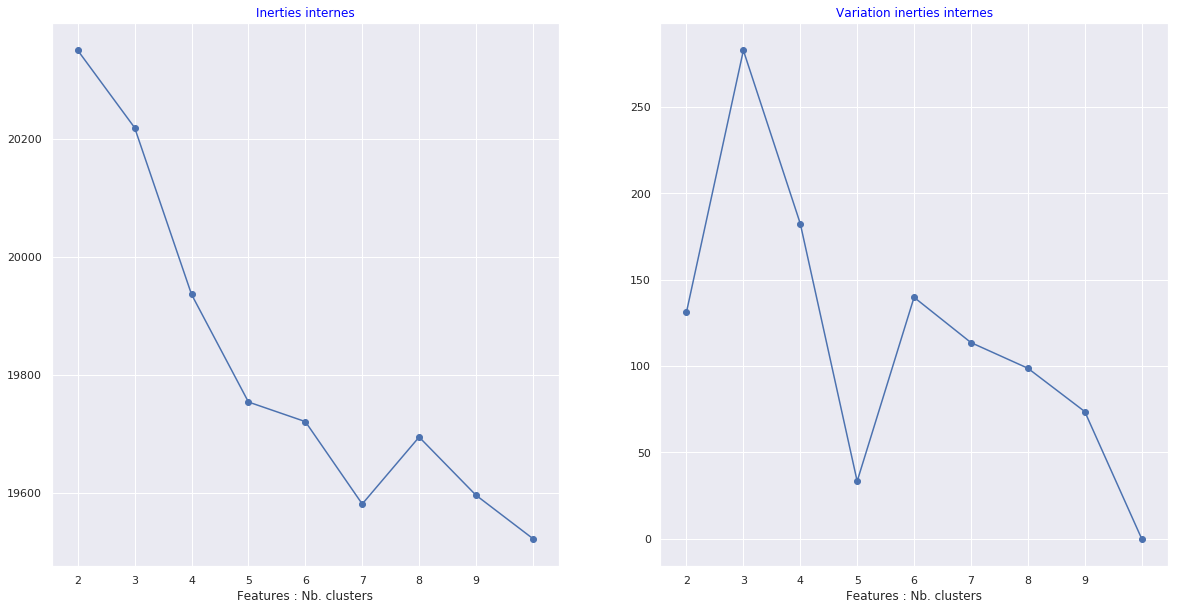

In [139]:
import p5_util_plot
import p5_util
is_reloaded = False
if is_reloaded is True:
    fileName = './data/dict_tfidf_clustering_kmeans.dump'
    dict_kmeans = p5_util.object_load(fileName)
    print("Records into dict_kmeans= "+str(len(dict_kmeans)))

x_label_0 = 'Features : Nb. clusters'
x_label_1 = 'Features : Nb. clusters'
cluster_start = list(dict_kmeans.keys())[0]
cluster_end = list(dict_kmeans.keys())[len(dict_kmeans)-1]
print(cluster_start, cluster_end)
p5_util_plot.plot_kmeans_interInertia(dict_kmeans, cluster_start, cluster_end\
                             ,[x_label_0, x_label_1]\
                             ,p_rows=1, p_cols=2, p_figsize=(20,10))

In [140]:
type(dict_kmeans[8])

sklearn.cluster.k_means_.KMeans

## 3.3. Word2Vec model

### Embedding corpus with Word2vec model

It is expected that ``word2vec`` learns relationships between words automatically.

* ``df_sof_train['Body']`` represents the corpus with which ``word2vec`` model is feeded.
* Once feed, ``word2vec`` will build a vocabulary, mean, a list of words (features) from which any word from corpus is vectorized.
* Matrix [Corpus words x Features] is stored in ``word2vec_model.wv.vectors``.


In [141]:
import p6_util
list_sentence = p6_util.get_list_sentence_from_df(df_sof_train, 'Body')

In [143]:
from gensim.models import Word2Vec
word2vec_model = Word2Vec(list_sentence, min_count=2, size=100, sg=1)

In [144]:
print(len(word2vec_model.wv.vocab))
len(word2vec_model.wv.vectors)

16837


16837

In [145]:
word2vec_model.save("word2vec_model")

## Test and performance

In [146]:
import pandas as pd
file_name="./data/test_StackOverFlow_BodyTitleTags.csv"
df_sof_test=pd.read_csv(file_name)

### Word2Vec model

* A post is randomly selected from test dataset.
* Then post is ipre-processed in order to feed M.L. model.

In [147]:
import random
import p6_util

i_random = random.choice(range(0, df_sof_test.shape[0]))
body= df_sof_test.Body.iloc[i_random]
title= df_sof_test.Title.iloc[i_random]
post = body+title
post=title

In [148]:
post=title
df_post = p6_util.preprocess_post(post)

* Tag counts is computed from test.
* Computed tags are returned with same number and same format then tags from test.

In [149]:
import p6_util
tag_count=p6_util.get_tag_count(df_sof_test.Tags.iloc[i_random])

list_computed_tag = p6_util.get_list_tag_from_post(df_post.Body.iloc[0], word2vec_model, max_tag=tag_count)
print("Computed tags = "+"".join(list_computed_tag))
print("")
print("Tags from test = "+df_sof_test.Tags.iloc[i_random])
print("------------------------------------------")
print("Posted question : \n")
print("Title : "+str(title))
print("")
print("Body: "+str(body))

Computed tags = <button>

Tags from test = <javascript>
------------------------------------------
Posted question : 

Title : How to open a new tab and change the current page

Body: <pre><code>&lt;form id="frm_1" name="frm_1" target="_self" method="GET" action="local_page.php" &gt;
&lt;/form&gt;
&lt;form id="tgt_1" name="tgt_1" target="_blank" method="POST" action="http://stackoverflow.com/" &gt;
&lt;/form&gt;
&lt;a onclick="test(event, '1'); " href="#" &gt;Click Here&lt;/a&gt;
&lt;script&gt;
    function test(event, id){
        document.getElementById("frm_"+id).submit;
        document.getElementById("tgt_"+id).submit;
    }
&lt;/script&gt;
</code></pre>

<p>Is it possible to open a new tab/window and change the current page ?</p>



## Plot 2D projection of Word2Vec embedded vocabulary

In [150]:
from gensim.models import Word2Vec

word2vec_model = Word2Vec.load("word2vec_model")

len(word2vec_model.wv.vocab.keys()), len(word2vec_model.wv.vectors)

(16837, 16837)

### Compute matrix for any word into corpus

**Load cleaned train-dataset**

In [151]:
import p5_util
file_name='./data/df_sof_train.dump'
df_sof_train=p5_util.object_load(file_name)

p5_util.object_load : fileName= ./data/df_sof_train.dump


**Get SOF corpus from dataframe**

In [152]:
import p6_util
list_corpus = p6_util.get_list_sentence_from_df(df_sof_train, 'Body')

In [153]:
list_tokenized_corpus=list()
i=0
for list_word in list_corpus:
    list_tokenized_corpus += list_word
    

In [154]:
len(list_tokenized_corpus[1:]), len(list_tokenized_corpus)

(775432, 775433)

### 2D t-SNE transformation

#### Load TDIF Matrix

In [158]:
import p5_util
file_name="./data/csr_matrix_tdif.dump"
csr_matrix = p5_util.object_load(file_name)

print(csr_matrix.shape)

p5_util.object_load : fileName= ./data/csr_matrix_tdif.dump
(24604, 1363)


**Get sample from CSR matrix**

In [159]:
import random
import numpy as np
arr = np.zeros(100)
array = csr_matrix.toarray()
#array_index_sample = random.sample(list(csr_matrix.shape), 10)

arr_index = np.random.randint(0,array.shape[0],1000)
array_sample = csr_matrix.toarray()[arr_index]

In [160]:
array_sample.shape, array.shape

((1000, 1363), (24604, 1363))

**Compute for embedded vocabulary t-SNE projection with different perplexity values**

In [161]:
import p5_util
if True:
    #X_std=word2vec_model.wv.vectors
    X_std = array_sample
    my_list_tsne_perplexity=[var for var in range(5,55,5)]
    dict_tsne_result = p5_util.tsne_2D_process_perplexity(X_std, tsne_iter=1000, list_tsne_perplexity=my_list_tsne_perplexity)

tSNE perplexity : 5/50 ...
tSNE perplexity : 10/50 ...
tSNE perplexity : 15/50 ...
tSNE perplexity : 20/50 ...
tSNE perplexity : 25/50 ...
tSNE perplexity : 30/50 ...
tSNE perplexity : 35/50 ...
tSNE perplexity : 40/50 ...
tSNE perplexity : 45/50 ...
tSNE perplexity : 50/50 ...


**Plot points issued from t-SNE transformations for each perplexity value**

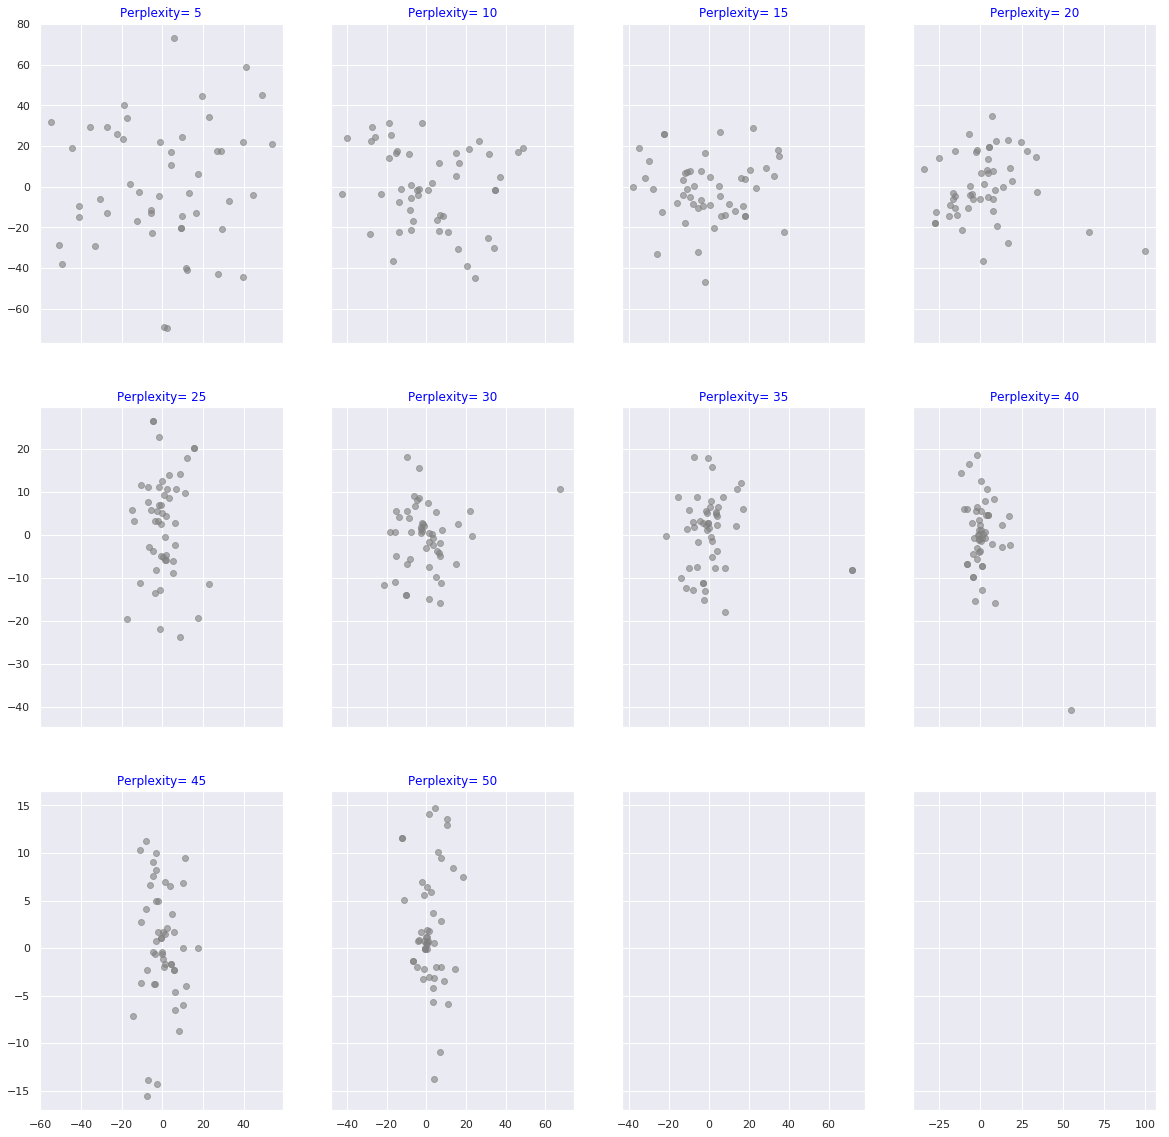

In [162]:
import p5_util_plot
if True :
    nb_col = 4     
    p5_util_plot.plot_2D_dict_tsne_result(dict_tsne_result, nb_col, ratio=0.05)

**Compute vocabulary t-SNE transformation for a fixed perplexity value**

In [168]:
import p5_util

X_std=word2vec_model.wv.vectors
print(X_std.shape)
perplexity=10
my_list_tsne_perplexity=[perplexity,]
dict_tsne_result = p5_util.tsne_2D_process_perplexity(X_std, tsne_iter=300, list_tsne_perplexity=my_list_tsne_perplexity)

(16837, 100)
tSNE perplexity : 10/50 ...


In [164]:
len(dict_tsne_result[perplexity]),X_std.shape

(16837, (16837, 100))

**Plot points issued from t-SNE embedded vocabulary transformation with words related to each point**

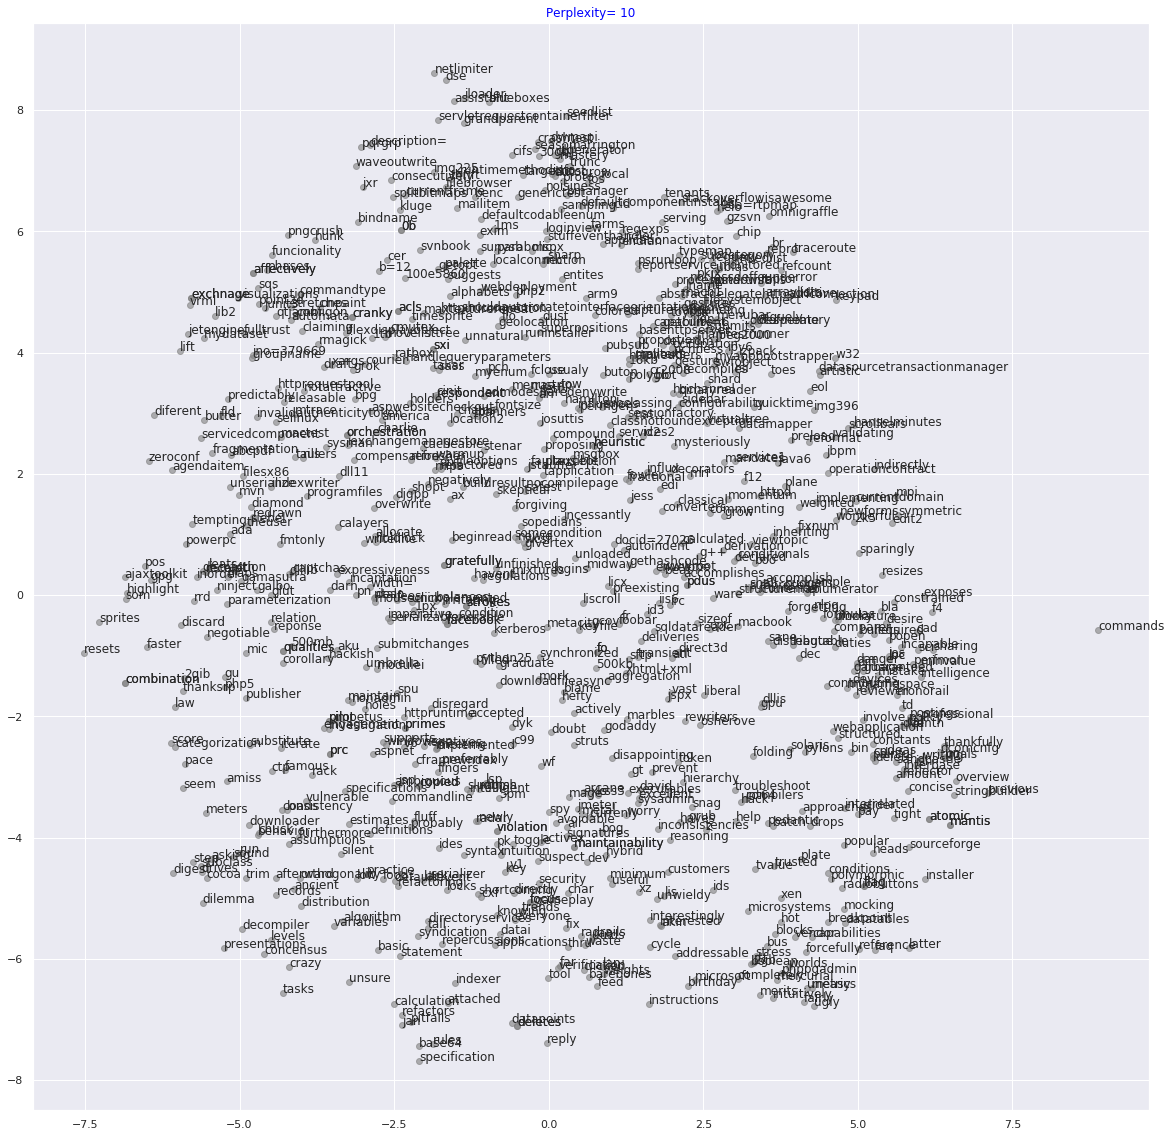

In [169]:
import numpy as np
import p5_util_plot

nb_col = 1
dict_tsne_result_part={perplexity:dict_tsne_result[perplexity]}
p_annotation = np.array(list(word2vec_model.wv.vocab.keys()))
p5_util_plot.plot_2D_dict_tsne_result(dict_tsne_result_part, nb_col, ratio=0.05, annotation=p_annotation)

### 2D PCA transformation

In [ ]:
import pandas as pd
df_pca=pd.DataFrame(X_std)

In [ ]:
df_pca.shape

In [ ]:
import p3_util_plot
z__ = p3_util_plot.df_pca_all_plot(df_pca, plot=True)

In [ ]:
from sklearn.decomposition import PCA

nb_components=600
pca = PCA(n_components=nb_components)
pca.fit(X_std)
X_pca = pca.transform(X_std)
print(X_pca.shape)

**Save reduced PCA**

In [ ]:
import p5_util
file_name="./data/pca_600_tdif.dump"
p5_util.object_dump(X_pca, file_name)

In [ ]:
import p3_util_plot
p_ratio=0.1
title = str(int(p_ratio*100))+" % Embedded TF-IDF vocabulary"
pca_=p3_util_plot.df_pca_components_plot(df_pca, None, nb_components=2, param_title=title, ratio=p_ratio)

In [ ]:
df_pca.shape

In [ ]:
import pandas as pd

list(word2vec_model.wv.vocab.keys())
df_vocab=pd.DataFrame(list(word2vec_model.wv.vocab.keys()))

In [ ]:
df_vocab.shape

In [ ]:
import p3_util_plot

p3_util_plot.df_pcs2_plot(df_pca, pca_)